Lab 1: BFS direction decision + 4 Voltage Layer

In [1]:
import numpy as np
import seaborn as sns
import networkx as nx
import random
from shapely.geometry import Polygon, LineString, Point
from helpers.border import find_closed_regions
from collections import defaultdict, deque
import matplotlib.pyplot as plt

In [2]:
from helpers.DataLoader import DataLoader

dataloader = DataLoader()

{2011: {'4': 137.0132274073625, '6': 1111.2687821693964, '13': 83.86127539221489, '17': 58.6911141635845, '18': 20.11433773972601, '19': 133.62121403401855, '20': 275.17582882899563, '21': 81.99160128767134, '22': 25.410677427625473, '23': 22.838262346301384, '24': 57.92736314889279, '25': 1169.3239390480455, '26': 295.28381834528665, '27': 87.60378801775074, '28': 314.0085483048399, '29': 112.64999899714633, '30': 139.0851280304333, '31': 92.01731766079936, '32': 84.61757959706624, '33': 545.3424647126167, '34': 1.5765732855936123, '35': 408.53229679533047, '36': 23.219439603881302, '37': 99.00818213244303, '38': 97.01066248340194, '39': 74.61811841171237, '40': 124.897440408117, '42': 124.11019815312804, '43': 16.2614513789954, '44': 144.7969910427636, '45': 80.73145196731768, '46': 69.47684656938333, '47': 82.12702316157524, '48': 201.88899179172475, '49': 16.469832138709968, '52': 127.188816897466, '53': 17.35893871430361, '54': 128.78756307170104, '55': 32.91992533727177, '56': 49

In [3]:
from helpers.policy import policy_helper_power_line_same_direction

direct_sync_dict = policy_helper_power_line_same_direction(dataloader.lines_to_station_pairs)

In [4]:
whether_lines_to_edges = {key: False for key in dataloader.direct_station_pairs_to_line.keys()}
registered_lines_number = 0
edges = []  # The local_edges used for illustration, Edge (x,y) represent a flow from x to y

In [5]:
def determine_directions_within_voltage_layer(local_edges, pivot_point):
    '''

    :param local_edges: Edge networks requiring a direction decision
    :param pivot_point: The pivot points within this network, which is certain to be the source of power within this network
    :return:
    '''

    substations = set()
    graph_neighbor = defaultdict(list)

    for (u, v) in local_edges:
        graph_neighbor[u].append(v)
        graph_neighbor[v].append(u)
        substations.add(u)
        substations.add(v)

    direct_edges = set()
    queue = deque()
    visited = set()

    # Append the power source point into the queue
    for g in pivot_point:
        if g in substations:
            queue.append(g)
            visited.add(g)

    while queue:
        current_station = queue.popleft()

        for neighbor in graph_neighbor[current_station]:
            forward_edge = (current_station, neighbor)
            reverse_edge = (neighbor, current_station)

            # Give the edge a direction if this edge have no direction before
            if forward_edge not in direct_edges and reverse_edge not in direct_edges:
                direct_edges.add(forward_edge)

                # if forward_edge in dataloader.undirect_station_pairs_to_line:
                #     sync_edges = search_power_lines_sync(
                #         forward_edge, direct_sync_dict, dataloader.undirect_station_pairs_to_line[forward_edge]
                #     )
                #     directed_edges.update(sync_edges)

            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)

    # BFS node search does not ensure all edges are covered
    # The direction of those edges do not affect the reach-ability of anything
    for u, v in local_edges:
        forward_edge = (u, v)
        reverse_edge = (v, u)

        if forward_edge not in direct_edges and reverse_edge not in direct_edges:
            # direct_edges.add(forward_edge)

            if random.choice([True, False]):
                direct_edges.add(forward_edge)
            else:
                direct_edges.add(reverse_edge)

            # if forward_edge in dataloader.undirect_station_pairs_to_line:
            #     sync_edges = search_power_lines_sync(
            #         forward_edge, direct_sync_dict, dataloader.undirect_station_pairs_to_line[forward_edge]
            #     )
            #     directed_edges.update(sync_edges)

    return list(direct_edges)


In [6]:
edges_69W, edges_138W, edges_240W, edges_500W = set(), set(), set(), set()
edges_with_voltage = [edges_69W, edges_138W, edges_240W, edges_500W]
substation_500_link_240, substation_240_link_138, substation_138_link_69 = set(), set(), set()

substation_voltage_under_power_line = {
    69: substation_138_link_69,
    138: substation_240_link_138,
    240: substation_500_link_240,
}

for station_pair in whether_lines_to_edges:
    lines = dataloader.undirect_station_pairs_to_line[station_pair]
    start, end = station_pair
    for line in lines:
        if dataloader.lines_to_voltage[line] == 69:
            # Add the substation into the lower voltage local_edges if not both of them under voltage
            if not (dataloader.substations_to_voltage[start] > 69 and dataloader.substations_to_voltage[end] > 69):
                if dataloader.substations_to_voltage[start] > 69:
                    substation_voltage_under_power_line[69].add(start)
                if dataloader.substations_to_voltage[end] > 69:
                    substation_voltage_under_power_line[69].add(end)
            else:
                continue

            edges_69W.add(station_pair)
        elif dataloader.lines_to_voltage[line] == 138:
            if not (dataloader.substations_to_voltage[start] > 138 and dataloader.substations_to_voltage[end] > 138):
                if dataloader.substations_to_voltage[start] > 138:
                    substation_voltage_under_power_line[138].add(start)
                if dataloader.substations_to_voltage[end] > 138:
                    substation_voltage_under_power_line[138].add(end)
            else:
                continue
            edges_138W.add(station_pair)
        elif dataloader.lines_to_voltage[line] == 240:
            if not (dataloader.substations_to_voltage[start] > 240 and dataloader.substations_to_voltage[end] > 240):

                if dataloader.substations_to_voltage[start] > 240:
                    substation_voltage_under_power_line[240].add(start)
                if dataloader.substations_to_voltage[end] > 240:
                    substation_voltage_under_power_line[240].add(end)
            else:
                continue

            edges_240W.add(station_pair)
        elif dataloader.lines_to_voltage[line] == 500:
            edges_500W.add(station_pair)
        elif dataloader.lines_to_voltage[line] == 0:
            # if dataloader.substations_to_voltage[start] == dataloader.substations_to_voltage[start]:
            print(start, end)
            lowest = min(dataloader.substations_to_voltage[start], dataloader.substations_to_voltage[end])
            if lowest == 69:
                edges_69W.add(station_pair)
            elif lowest == 138:
                edges_138W.add(station_pair)
            elif lowest == 240:
                edges_240W.add(station_pair)
            elif lowest == 500:
                edges_500W.add(station_pair)


194S RD15S
217S RD14S
511S 102S
SS-2 5S
CALGARY ENERGY CENTER CEC SS-162
864S 841S
29EDD-22 29EDD-2
29EDD-67 29EDD-93
29EDD-9 29EDD-8
29EDD-46 29EDD-64
29EDD-64 29EDD-83
29EDD-84 29EDD-83
29EDD-46 29EDD-84
MHS-6 CMH PLANT
ROSSDALE BELLAMY


In [7]:
substation_with_generator_69 = [substation for substation in dataloader.substations_to_generators if
                                substation in dataloader.substations_to_voltage and dataloader.substations_to_voltage[
                                    substation] == 69]
substation_with_generator_138 = [substation for substation in dataloader.substations_to_generators if
                                 substation in dataloader.substations_to_voltage and dataloader.substations_to_voltage[
                                     substation] == 138]
substation_with_generator_240 = [substation for substation in dataloader.substations_to_generators if
                                 substation in dataloader.substations_to_voltage and dataloader.substations_to_voltage[
                                     substation] == 240]
substation_with_generator_500 = [substation for substation in dataloader.substations_to_generators if
                                 substation in dataloader.substations_to_voltage and dataloader.substations_to_voltage[
                                     substation] == 500]

substation_with_generator_with_voltage = [substation_with_generator_69, substation_with_generator_138,
                                          substation_with_generator_240, substation_with_generator_500]
substation_voltage_cross_point = [substation_138_link_69, substation_240_link_138, substation_500_link_240, []]


In [8]:
for index in range(0, 4):
    # for index in range(1, 2):
    edges_set = edges_with_voltage[index]
    substation_with_generator = substation_with_generator_with_voltage[index]
    substation_cross_point = substation_voltage_cross_point[index]

    # for edges_set in [edges_240W]:
    directed_edges = determine_directions_within_voltage_layer(edges_set,
                                                               substation_with_generator + list(substation_cross_point))

    for direct_edge in directed_edges:
        direct_edge_start, direct_edge_end = direct_edge
        # if direct_edge not in local_edges:
        if (direct_edge_start, direct_edge_end) not in edges and (direct_edge_end, direct_edge_start) not in edges:
            edges.append(direct_edge)
            if (direct_edge_start, direct_edge_end) in whether_lines_to_edges:
                whether_lines_to_edges[(direct_edge_start, direct_edge_end)] = True
            if (direct_edge_end, direct_edge_start) in whether_lines_to_edges:
                whether_lines_to_edges[(direct_edge_end, direct_edge_start)] = True
            registered_lines_number += 1

    print(f"Register rate: {registered_lines_number} / {len(whether_lines_to_edges.keys())}")


Register rate: 98 / 855
Register rate: 658 / 855
Register rate: 830 / 855
Register rate: 842 / 855


In [9]:
print([edge for edge in whether_lines_to_edges if not whether_lines_to_edges[edge]])

[('102S', '520S'), ('65S', '392S'), ('38S', '71S'), ('37S', '71S'), ('805S', 'WOODCROFT'), ('MEADOWLARK', 'GARNEAU'), ('805S', 'MEADOWLARK'), ('WOODCROFT', 'ROSSDALE'), ('VICTORIA', 'BELLAMY'), ('ROSSDALE', 'STRATHCONA'), ('STRATHCONA', 'LAMBTON'), ('STRATHCONA', 'DOME'), ('NAMAO', '987S')]


In [10]:
# Process the local_edges in case there's repeats
edges = list(set(edges))

In [11]:
# Configuration Dictionary
config = {
    "line": {
        "visible": True,
        "show_names": False,
        "filter_voltage": True,
        "target_voltages": [69, 138, 240, 500]
    },
    "station": {
        "color": "red",
        "edge_color": "black",
        "visible": True,
        "show_names": False
    },
    "city": {
        "color": "yellow",
        "edge_color": "black",
        "visible": False,
        "show_names": False
    },
    "region": {
        "visible": True,
        "show_names": True,
        "colors": ["lightblue", "lightgreen", "lightcoral", "lightsalmon", "lightgray"]
    }

}

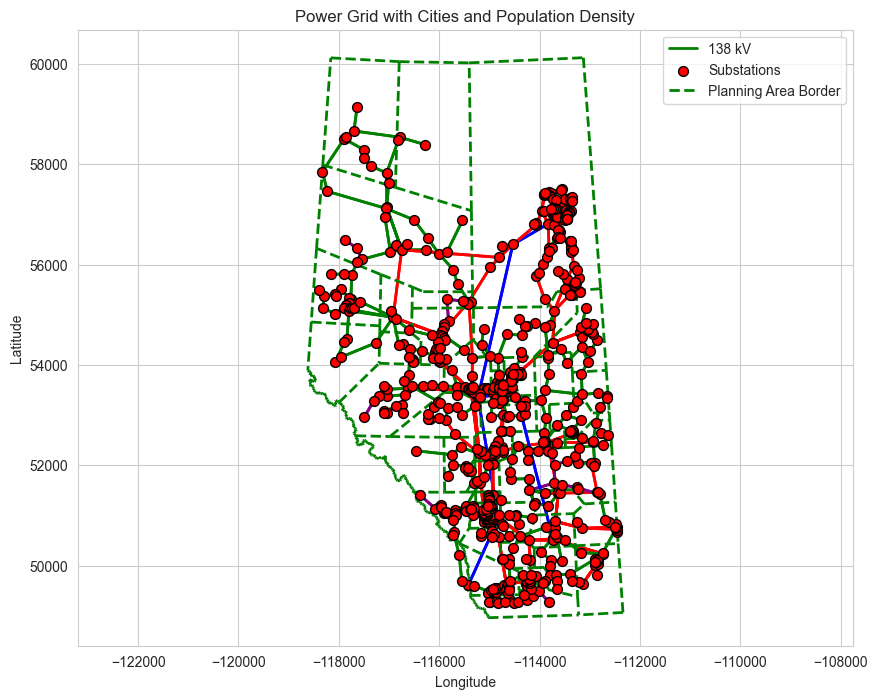

In [12]:
plt.figure(figsize=(10, 8))

# Assuming dataloader is an instance of DataLoader and config is defined
first_line = True
first_border = True

# Plot lines
if config["line"]["visible"]:
    for (station_x, station_y), lines in dataloader.undirect_station_pairs_to_line.items():
        start_coords = dataloader.substations_to_coordinates[station_x]
        end_coords = dataloader.substations_to_coordinates[station_y]

        filtered_lines = [line for line in lines if
                          dataloader.lines_to_voltage[line] in config["line"]["target_voltages"]] if config["line"][
            "filter_voltage"] else lines

        for line in filtered_lines:
            voltage = dataloader.lines_to_voltage[line]
            color = dataloader.voltage_colors.get(voltage, "black")  # Default to black if voltage is not mapped
            plt.plot([start_coords[0], end_coords[0]], [start_coords[1], end_coords[1]], color=color, linewidth=2,
                     label=f"{voltage} kV" if first_line else "")

            if config["line"]["show_names"]:
                mid_x = (start_coords[0] + end_coords[0]) / 2
                mid_y = (start_coords[1] + end_coords[1]) / 2
                plt.text(mid_x, mid_y, f"{line} ({voltage} kV)", fontsize=8, color="black", ha="center")

            first_line = False

# Plot substations
if config["station"]["visible"]:
    x_vals, y_vals = zip(*dataloader.substations_to_coordinates.values())

    plt.scatter(x_vals, y_vals, color=config["station"]["color"], s=50, label="Substations",
                edgecolors=config["station"]["edge_color"], zorder=3)

    if config["station"]["show_names"]:
        for substation, coords in dataloader.substations_to_coordinates.items():
            plt.text(coords[0], coords[1], substation, fontsize=9, ha="right", color="black", zorder=4)

if config['region']["visible"]:
    for start, end in dataloader.planning_area_border_edges:
        plt.plot([start[0], end[0]], [start[1], end[1]],
                 "g--", linewidth=2, label="Planning Area Border" if first_border else "")
        first_border = False

# Plot cities
if config["city"]["visible"]:
    x_vals, y_vals = zip(*dataloader.city_to_coordinates.values())
    plt.scatter(x_vals, y_vals, color=config["city"]["color"], s=80, label="Cities",
                edgecolors=config["city"]["edge_color"], zorder=4)

    if config["city"]["show_names"]:
        for city_name, (x, y) in dataloader.city_to_coordinates.items():
            plt.text(x, y, city_name, fontsize=10, ha="left", color="black", zorder=5)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Power Grid with Cities and Population Density")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

In [13]:
from helpers.position import map_cities_to_planning_areas, map_stations_to_planning_areas, get_substations_in_city_areas

planning_area_closed_regions = find_closed_regions(dataloader.planning_area_border_df)
city_closed_regions = find_closed_regions(dataloader.city_border_df)

planning_area_to_cities = map_cities_to_planning_areas(planning_area_closed_regions, dataloader.city_to_coordinates)

planning_area_to_stations = map_stations_to_planning_areas(planning_area_closed_regions,
                                                           dataloader.substations_to_coordinates)
substations_in_city_areas = get_substations_in_city_areas(city_closed_regions, dataloader.substations_to_coordinates)

planning_area_colors = sns.color_palette("Paired", len(planning_area_closed_regions))
random.shuffle(planning_area_colors)


In [14]:
stations_outside_planning_areas = []

for name, (x, y) in dataloader.substations_to_coordinates.items():
    station_point = Point(x, y)
    in_any_area = False

    for polygon in planning_area_closed_regions:
        if polygon.contains(station_point):
            in_any_area = True
            break

    if not in_any_area:
        stations_outside_planning_areas.append(name)

print("Stations outside any planning area:", stations_outside_planning_areas)

# Handle exceptions: A few Alberta substations are not in the lands (not covered within any planning areas)
planning_area_to_stations["53"].append('978S')
planning_area_to_stations["53"].append('CRANBROOK B2S')
planning_area_to_stations["53"].append('NATAL')

Stations outside any planning area: ['978S', 'CRANBROOK B2S', 'NATAL']


In [15]:
from helpers.demand import estimate_substation_demand_average_within_planning_area, \
    estimate_substation_demand_average_within_planning_area_urban_check

activate_urban_check = True

year = 2023

if activate_urban_check:
    substation_demand_dict = estimate_substation_demand_average_within_planning_area_urban_check(
        planning_area_to_stations, dataloader.planning_area_demand[year], substations_in_city_areas,
        dataloader.get_city_population_ratio())
else:
    substation_demand_dict = estimate_substation_demand_average_within_planning_area(planning_area_to_stations,
                                                                                     dataloader.planning_area_demand[year])

3416121.0


In [16]:
# Configuration Dictionary
config = {
    "line": {
        "visible": False,
        "show_names": False,
        "filter_voltage": True,
        "target_voltages": [0, 69, 138, 240, 500]
    },
    "station": {
        "color": "red",
        "edge_color": "black",
        "visible": False,
        "show_names": False
    },
    "city": {
        "color": "yellow",
        "edge_color": "black",
        "visible": False,
        "show_names": False
    },
    "region": {
        "visible": False,  # Whether showing planning area
        "show_names": True,  # Whether showing planning area name
        "colors": ["lightblue", "lightgreen", "lightcoral", "lightsalmon", "lightgray"]
    }
}


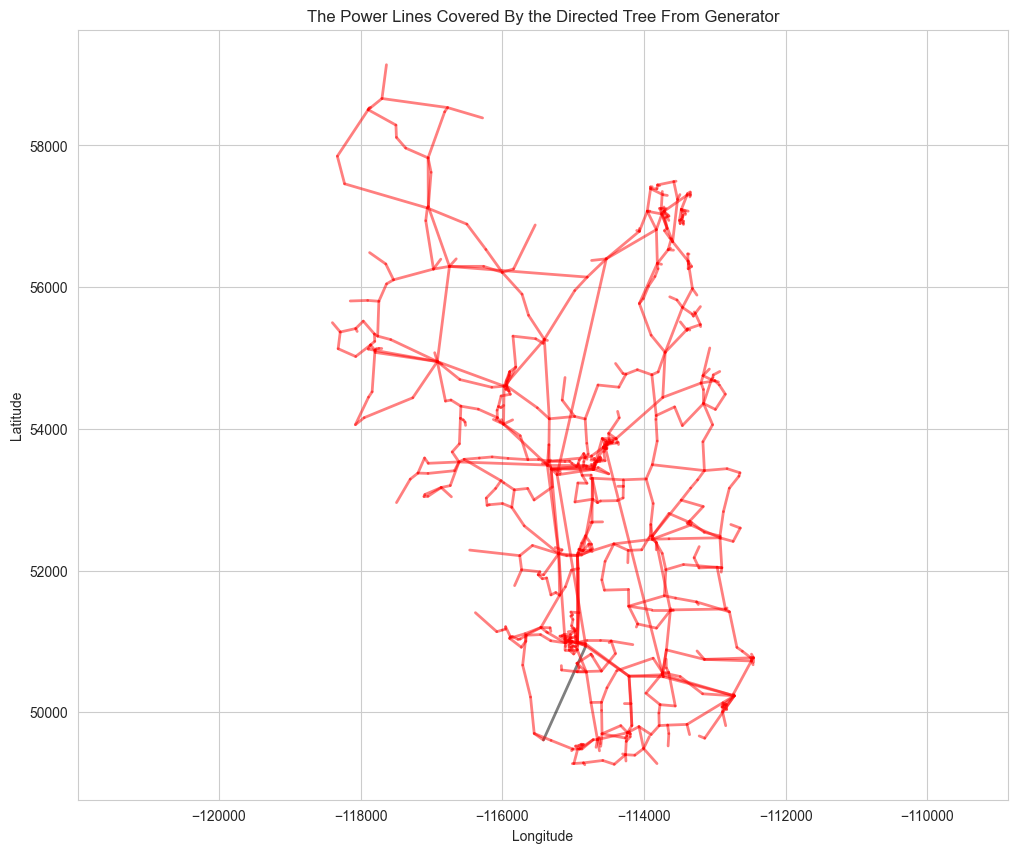

In [17]:
highlight_color = "red"

fig, ax = plt.subplots(figsize=(12, 10))

if config["region"]["visible"]:
    for idx, polygon in enumerate(planning_area_closed_regions):
        x, y = polygon.exterior.xy
        region_name = dataloader.planning_area_gen_area_dict[idx + 1]
        region_color = config["region"]["colors"][idx % len(config["region"]["colors"])]

        ax.fill(x, y, color=region_color, alpha=0.8, label=f"Region {region_name}")
        ax.plot(x, y, 'k-', linewidth=2)


def find_reachable_edges(local_edges, generators_to_substations):
    pfg = nx.DiGraph()
    pfg.add_edges_from(local_edges)

    all_reachable_nodes = set()
    pdf_edges = set(pfg.edges())

    for generator_station in set(generators_to_substations.values()):
        if generator_station in pfg:
            all_reachable_nodes.update(nx.descendants(pfg, generator_station))

    local_reachable_edges = {edge for edge in pdf_edges if
                             edge[0] in all_reachable_nodes or edge[1] in all_reachable_nodes}

    local_unreachable_edges = pdf_edges - local_reachable_edges
    return pdf_edges, local_reachable_edges, local_unreachable_edges


all_edges, reachable_edges, unreachable_edges = find_reachable_edges(edges, dataloader.generators_to_substations)


def find_edges_within_voltage(local_edges, target_voltages):
    result_edges = []
    for edge in local_edges:
        local_lines = dataloader.undirect_station_pairs_to_line[edge]
        local_filtered_lines = (
            [line for line in local_lines if dataloader.lines_to_voltage[line] in target_voltages]
        )

        if local_filtered_lines:
            result_edges.append(edge)

    return result_edges


all_edges = find_edges_within_voltage(all_edges, config["line"]["target_voltages"])
reachable_edges = find_edges_within_voltage(reachable_edges, config["line"]["target_voltages"])
unreachable_edges = find_edges_within_voltage(unreachable_edges, config["line"]["target_voltages"])

# print("Reachable:", reachable_edges)
# print("Non Reachable:", unreachable_edges)

# Color definition
generator_connected_color = "red"  # Color for Station with Generator
default_station_color = "blue"  # Default Station Color

plotted_labels = set()
for (station_x, station_y) in all_edges:
    if station_x in dataloader.substations_to_coordinates and station_y in dataloader.substations_to_coordinates:
        start_coords = dataloader.substations_to_coordinates[station_x]
        end_coords = dataloader.substations_to_coordinates[station_y]

        if (station_x, station_y) in reachable_edges:
            color = "red"
        else:
            color = "black"

        # Draw the station
        if config["station"]["visible"]:
            for station_name in [station_x, station_y]:
                is_generator_connected = station_name in set(dataloader.generators_to_substations.values())
                station_color = generator_connected_color if is_generator_connected else default_station_color
                label = "Generator-Connected" if is_generator_connected else "Substations"

                coordinates = dataloader.substations_to_coordinates[station_name]

                if label not in plotted_labels:
                    ax.scatter(coordinates[0], coordinates[1], color=station_color, s=50, label=label,
                               edgecolors=config["station"]["edge_color"], zorder=3)
                    plotted_labels.add(label)
                else:
                    ax.scatter(coordinates[0], coordinates[1], color=station_color, s=50,
                               edgecolors=config["station"]["edge_color"], zorder=3)

                if config["station"]["show_names"]:
                    ax.text(coordinates[0], coordinates[1], station_name, fontsize=9, ha="right", color="black",
                            zorder=4)

        ax.plot(
            [start_coords[0], end_coords[0]],
            [start_coords[1], end_coords[1]],
            color=color,
            linewidth=2,
            alpha=0.5
        )

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("The Power Lines Covered By the Directed Tree From Generator")
plt.grid(True)
plt.axis("equal")
plt.show()


In [18]:
# Construct directed graph
power_flow_graph = nx.DiGraph()
power_flow_graph.add_edges_from(edges)  # Add the determined directions

substation_to_load = {s: 0.0 for s in substation_demand_dict.keys()}

# Calculate the power contribution of each generator
for generator, station in dataloader.generators_to_substations.items():
    if station not in power_flow_graph:
        continue

    # The supply from each generator
    generator_capacity = float(dataloader.generators_to_capacities.get(generator, 0))

    # All the reachable substations
    reachable_substations = set(nx.descendants(power_flow_graph, station))
    reachable_substations.add(station)

    # The total demand for reachable substations
    total_demand_index = float(sum(substation_demand_dict.get(s, 0)
                                   for s in reachable_substations))
    if total_demand_index == 0:
        continue

    # Allocate the generation supply to each substations
    for substation in reachable_substations:
        demand_index = float(substation_demand_dict.get(substation, 0))
        load_ratio = demand_index / total_demand_index
        substation_to_load[substation] += load_ratio * generator_capacity

In [19]:
import cvxpy as cp

nodes = list(set(node for edge in edges for node in edge))
lines = edges

# Initialize generation for all nodes to zero
generation = {node: 0 for node in nodes}

# Accumulate generation capacities for substations that appear in local_edges
for generator, substation in dataloader.generators_to_substations.items():
    if substation in generation:  # Only count substations that appear in local_edges
        capacity = dataloader.generators_to_capacities.get(generator, 0)  # Get generator capacity
        generation[substation] += capacity  # Add capacity to the corresponding substation

# Load consumption at substations
consumption = substation_to_load

# Define variables: power flow on each line (must be non-negative)
F = {line: cp.Variable(nonneg=True) for line in lines}

# Additional slack variable, only allowing positive errors
slack_plus = {i: cp.Variable(nonneg=True) for i in
              nodes}  # Represents positive deviation (only compensates for shortages)

# Generate flow conservation constraints (ensuring left side ≥ 0)
constraints = []
for i in nodes:
    inflow = sum(F[(j, i)] for j, k in lines if k == i)  # Total incoming flow to node i
    outflow = sum(F[(i, j)] for k, j in lines if k == i)  # Total outgoing flow from node i

    # Ensure that inflow + generation is at least equal to outflow + consumption
    constraints.append(inflow + generation[i] - outflow - consumption[i] >= 0)

    # Allow a slack variable (but only positive)
    constraints.append(inflow + generation[i] - outflow - consumption[i] == slack_plus[i])

# Objective function: minimize the sum of slack_plus variables (to reduce imbalance as much as possible)
objective = cp.Minimize(sum(slack_plus[i] for i in nodes))

# Solve the optimization problem
prob = cp.Problem(objective, constraints)
prob.solve()

# Output results
print("Power line flow distribution:")
for line in lines:
    print(f"Line {line}: Load = {F[line].value:.2f}")

print("\nFlow conservation error (Slack):")
for i in nodes:
    print(f"Node {i}: Slack+ = {slack_plus[i].value:.2f}")

# Check solver status
if prob.status == "optimal":
    print("Found the globally optimal solution!")
elif prob.status == "optimal_inaccurate":
    print("Found an approximately optimal solution (potential numerical issues)")
elif prob.status == "infeasible":
    print("The problem is infeasible, check constraints!")
elif prob.status == "unbounded":
    print("The problem is unbounded, check if constraints are properly set!")
else:
    print(f"Solver status unknown: {prob.status}")


Power line flow distribution:
Line ('275S', '562S'): Load = 12.72
Line ('730S', '811S'): Load = 25.62
Line ('244S', '649S'): Load = 21.53
Line ('17S', '580S'): Load = 2.50
Line ('848S', 'MILLENIUM 29EDD-1'): Load = 55.99
Line ('SS-14', 'SS-36'): Load = 33.42
Line ('735S', '727S'): Load = 6.45
Line ('SS-16', 'SS-15'): Load = 11.20
Line ('410S', '409S'): Load = 0.51
Line ('963S', '802S'): Load = 373.22
Line ('951S', '2011S'): Load = 10.54
Line ('63S', '87S'): Load = 83.85
Line ('354S', '312S'): Load = 47.33
Line ('535S', '482S'): Load = 4.58
Line ('89S', '12S'): Load = 97.38
Line ('227S', '339S'): Load = 0.26
Line ('1029S', '406S'): Load = 1.18
Line ('653S', '284S'): Load = 90.21
Line ('379S', '502S'): Load = 69.08
Line ('851S', '785S'): Load = 1.78
Line ('946S', '959S'): Load = 231.45
Line ('PETROLIA', 'ARGYLL'): Load = 2.25
Line ('853S', '855S'): Load = 1.26
Line ('428S', '431S'): Load = 9.09
Line ('709S', '956S'): Load = 14.52
Line ('876S', '834S'): Load = 47.14
Line ('SS-2', 'SS-5'):

In [20]:
line_to_load = {line: F[line].value for line in lines}


Flow Conservation Validation Results:
Node 746S: inflow + generation = 7.61, outflow + consumption = 7.61, error = -0.00
Node 120S: inflow + generation = 261.71, outflow + consumption = 261.71, error = 0.00
Node WAP 1S: inflow + generation = 18.00, outflow + consumption = 18.00, error = 0.00
Node 95S: inflow + generation = 43.00, outflow + consumption = 43.00, error = -0.00
Node SS-3: inflow + generation = 21.63, outflow + consumption = 21.63, error = 0.00
Node 960S: inflow + generation = 1.91, outflow + consumption = 1.91, error = -0.00
Node 257S: inflow + generation = 25.48, outflow + consumption = 25.48, error = 0.00
Node 531S: inflow + generation = 4.47, outflow + consumption = 4.47, error = -0.00
Node CMH PLANT: inflow + generation = 341.00, outflow + consumption = 341.00, error = 0.00
Node 739S: inflow + generation = 100.07, outflow + consumption = 100.07, error = -0.00
Node 936S: inflow + generation = 3.49, outflow + consumption = 3.49, error = 0.00
Node STEEPBANK 836S: inflow 

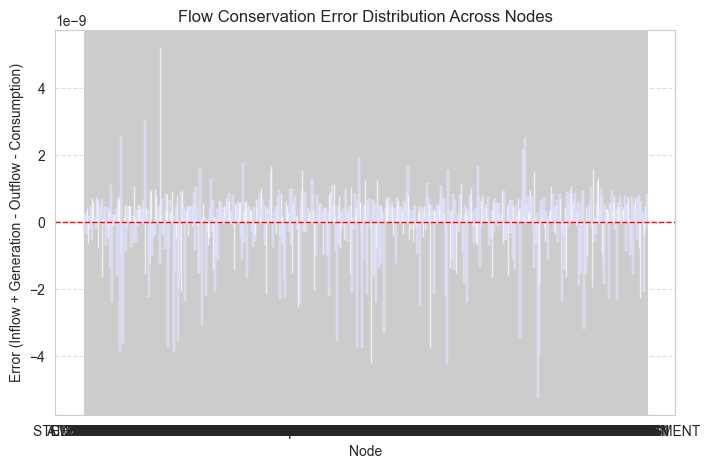

In [21]:
# Initialize validation results
validation_results = {}

# Iterate through all nodes to verify flow conservation
for i in nodes:
    inflow = sum(line_to_load[(j, i)] for j, k in lines if k == i)  # Inflow to node i
    outflow = sum(line_to_load[(i, j)] for k, j in lines if k == i)  # Outflow from node i
    left_side = inflow + generation[i]
    right_side = outflow + consumption[i]

    # Calculate error
    error = left_side - right_side

    # Store in validation dictionary
    validation_results[i] = {
        "inflow": inflow,
        "generation": generation[i],
        "outflow": outflow,
        "consumption": consumption[i],
        "left_side": left_side,
        "right_side": right_side,
        "error": error
    }

# Output validation results
print("\nFlow Conservation Validation Results:")
for node, result in validation_results.items():
    print(
        f"Node {node}: inflow + generation = {result['left_side']:.2f}, outflow + consumption = {result['right_side']:.2f}, error = {result['error']:.2f}")

# If all errors are close to 0, the validation passes
if all(abs(result["error"]) < 1e-6 for result in validation_results.values()):
    print("\n✅ Validation Passed: All nodes satisfy flow conservation!")
else:
    print("\n❌ Validation Failed: Some nodes do not satisfy flow conservation!")

# Extract nodes and error values
nodes_list = list(validation_results.keys())
errors = [validation_results[node]["error"] for node in nodes_list]

# Plot error distribution
plt.figure(figsize=(8, 5))
plt.bar(nodes_list, errors, color='b', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add reference line

plt.xlabel("Node")
plt.ylabel("Error (Inflow + Generation - Outflow - Consumption)")
plt.title("Flow Conservation Error Distribution Across Nodes")
plt.xticks(nodes_list)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.show()


In [22]:
if 'validation_results' in globals():
    max_error_node = max(validation_results, key=lambda x: abs(validation_results[x]["error"]))
    max_error_value = validation_results[max_error_node]["error"]

    # Pring Max Error
    print(f"Max Error Node {max_error_node}, Error = {max_error_value:.8f}")
else:
    print("Error: validation_results is not defined.")


Max Error Node CRANBROOK B2S, Error = -0.00000001


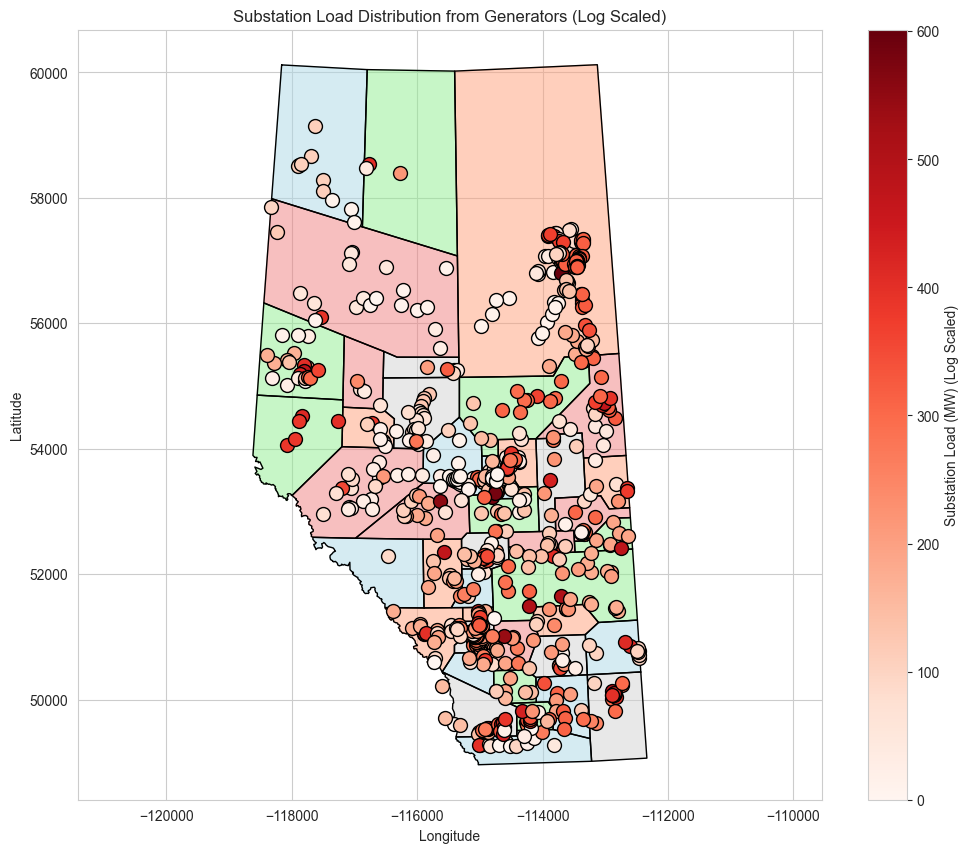

In [23]:
max_load = max(substation_to_load.values()) if substation_to_load else 1

fig, ax = plt.subplots(figsize=(12, 10))

for idx, polygon in enumerate(planning_area_closed_regions):
    x, y = polygon.exterior.xy
    region_color = config["region"]["colors"][idx % len(config["region"]["colors"])]
    ax.fill(x, y, color=region_color, alpha=0.5)
    ax.plot(x, y, 'k-', linewidth=1)

for station_name, (x, y) in dataloader.substations_to_coordinates.items():
    load = substation_to_load.get(station_name, 0)

    normalized_load = np.log1p(load) / np.log1p(max_load)
    color = plt.cm.Reds(normalized_load)

    ax.scatter(x, y, color=color, s=100, edgecolor="black", zorder=3)

sm = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=max_load))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Substation Load (MW) (Log Scaled)")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Substation Load Distribution from Generators (Log Scaled)")
plt.grid(True)
plt.axis("equal")
plt.show()


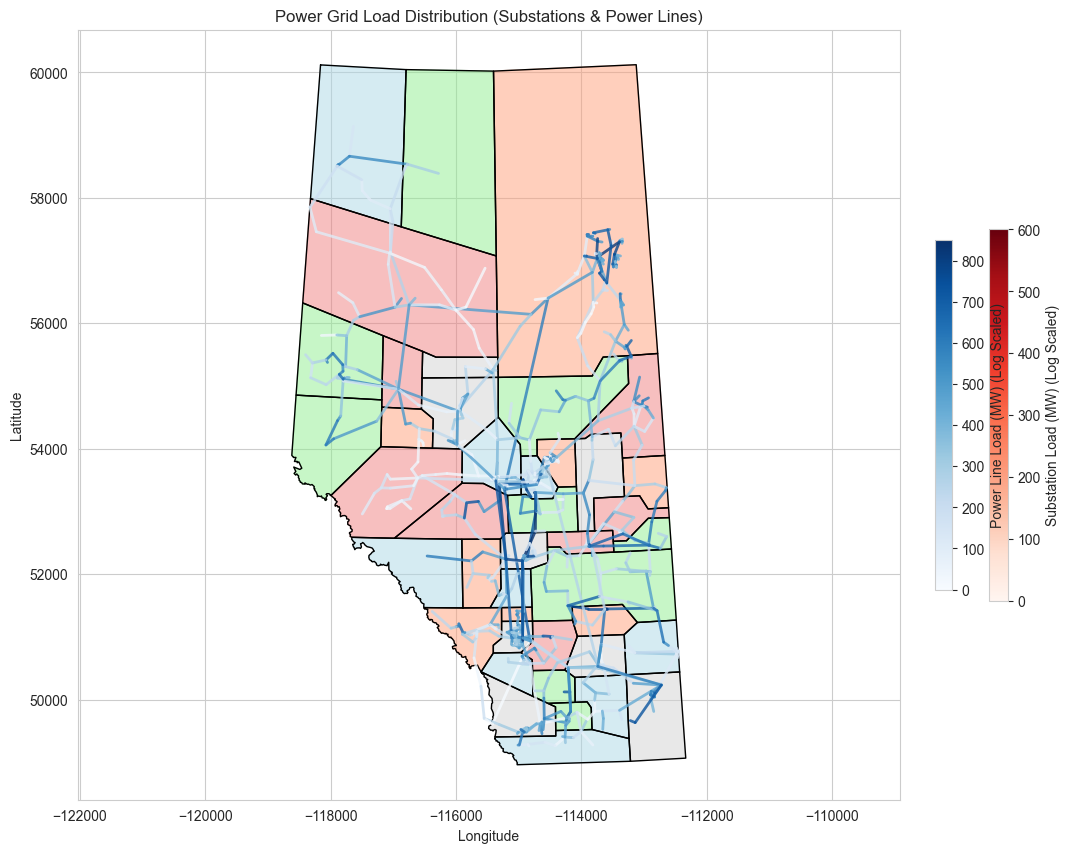

In [24]:
max_line_load = max(line_to_load.values()) if line_to_load else 1

fig, ax = plt.subplots(figsize=(12, 10))

for idx, polygon in enumerate(planning_area_closed_regions):
    x, y = polygon.exterior.xy
    region_color = config["region"]["colors"][idx % len(config["region"]["colors"])]
    ax.fill(x, y, color=region_color, alpha=0.5)
    ax.plot(x, y, 'k-', linewidth=1)

for (station_x, station_y), load in line_to_load.items():
    start_coords = dataloader.substations_to_coordinates.get(station_x)
    end_coords = dataloader.substations_to_coordinates.get(station_y)

    if start_coords and end_coords:
        normalized_load = np.log1p(load) / np.log1p(max_line_load)
        color = plt.cm.Blues(normalized_load)

        ax.plot([start_coords[0], end_coords[0]],
                [start_coords[1], end_coords[1]],
                color=color, linewidth=2, alpha=0.8)

max_station_load = max(substation_to_load.values()) if substation_to_load else 1

sm_stations = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=max_station_load))
cbar_stations = plt.colorbar(sm_stations, ax=ax, fraction=0.02, pad=0.04)
cbar_stations.set_label("Substation Load (MW) (Log Scaled)")

sm_lines = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=0, vmax=max_line_load))
cbar_lines = plt.colorbar(sm_lines, ax=ax, fraction=0.02, pad=0.04)
cbar_lines.set_label("Power Line Load (MW) (Log Scaled)")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Power Grid Load Distribution (Substations & Power Lines)")
plt.grid(True)
plt.axis("equal")
plt.show()
